In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM4/Optimization_CaseStudy/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/data/upgrad/SEM4/Optimization_CaseStudy


In [ ]:
# Importing Libraries 

!pip install pyomo
!apt-get install -y -qq glpk-utils coinor-cbc

import pandas as pd
import numpy as np
import math

from pyomo.environ import *
from __future__ import division
from pyomo.opt import SolverFactory
from openpyxl import load_workbook

     |████████████████████████████████| 9.5MB 6.0MB/s 
     |████████████████████████████████| 256kB 55.9MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 163kB 49.1MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../00-libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../01-libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../02-libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../03-libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected p

In [ ]:
# Reading the data from Excel workbook
InputData = "Staffing+Data.xlsx"

demand = pd.read_excel(InputData,sheet_name='DemandData')
StaffAvailability = pd.read_excel(InputData,sheet_name='StaffAvailability')
Cost = pd.read_excel(InputData,sheet_name='Cost')
Service_rate = pd.read_excel(InputData,sheet_name='ServiceRate')

# Calculating monthly salary
Cost['MonthlySalary'] = Cost['AnnualSalary']/12

## Data pre-processing 

In [ ]:
# Creating the required Python data structures for indexes and parameters

demand_state_month = demand.set_index(['State', 'Month'])['Demand'].to_dict()

Avg_availability = StaffAvailability.set_index(['State', 'Month'])['StaffAvPer'].to_dict()

LB_availability = StaffAvailability.set_index(['State', 'Month'])['LB'].to_dict()

UB_availability = StaffAvailability.set_index(['State', 'Month'])['UB'].to_dict()

AnnualSalary = Cost.set_index(['State'])['AnnualSalary'].to_dict()

MonthlySalary = Cost.set_index(['State'])['MonthlySalary'].to_dict()

UnitOutSourceCost = Cost.set_index(['State', 'Month'])['UnitOutSourceCost'].to_dict()

app_processed_by_staff = Service_rate.iloc[0,0] #number of applications processed by staff when the availability is 100%

print("Number of applications processed by staff when the availability is 100%:",app_processed_by_staff)

Number of applications processed by staff when the availability is 100%: 40


# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [ ]:
# Creating a model instance
model = ConcreteModel()

In [ ]:
# Extracting the unique values of State and Month which will act as indexes for
#the decision variables and the parameters

State=demand['State'].unique()
Month=demand['Month'].unique()

In [ ]:
# Define Pyomo sets and Parameters
model.State = Set(initialize = State.tolist(), doc = "State" )
model.Month = Set(initialize = Month.tolist(), doc = "Month" )

model.demand_state_month = Param(model.State, model.Month, initialize= demand_state_month, doc= "Demand for each State per Month")
model.Avg_availability = Param(model.State, model.Month, initialize= Avg_availability, doc= "Avg Availability of Internal Staff")
model.LB_availability = Param(model.State, model.Month, initialize= LB_availability, doc= "Worst Case Availability")
model.UB_availability = Param(model.State, model.Month, initialize= UB_availability, doc= "Best Case Availability")
model.MonthlySalary = Param(model.State, initialize= MonthlySalary, doc= "Monthly Salary")
model.UnitOutSourceCost = Param(model.State, model.Month, initialize= UnitOutSourceCost, doc= "Outsourcing Cost per Application")

In [ ]:
# Decision variables

# Decision variable for internal staff members (Count of internal staff members)
model.x = Var(model.State, model.Month, within=NonNegativeReals, doc= "Number of Internal Staff") 

# Decision variable for outsourced vendors (Number of applications processed by outsourced vendors)
model.y = Var(model.State, model.Month, within=NonNegativeIntegers, doc = "Number of Applications Outsourced to Vendors")

In [ ]:
# Constraints

# Maximum percentage of applications that can be processed by vendors in different states
max_ratio = {'A':0.3, 'B':0.4, 'C':1}

def max_applications_func(model,s,m):
  return model.y[s,m] <= max_ratio[s]*model.demand_state_month[s,m]

model.max_applications = Constraint(model.State, model.Month, rule=max_applications_func)

# For each month with respect to its State, the sum of total applications processed by vendors and total applications 
# processed by the internal staff should be equal to the total number of applications

def total_applications_func(model,s,m):
  return model.demand_state_month[s,m] == model.Avg_availability[s,m]*app_processed_by_staff*model.x[s,m] + model.y[s,m]

model.total_applications = Constraint(model.State,model.Month,rule=total_applications_func)

In [ ]:
# Objective function

def obj_rule(model):
  total_staff_cost = sum(model.MonthlySalary[s]*model.x[s,m] for s in model.State for m in model.Month)
  total_vendor_cost = sum(model.UnitOutSourceCost[s,m]*model.y[s,m] for s in model.State for m in model.Month)
  return total_staff_cost + total_vendor_cost

model.objvalue = Objective(rule=obj_rule, sense=minimize)

In [ ]:
# Invoking the solver
result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.015135765075683594
# ----------------------------------------------------------
#   Solution Information
# ----------

In [ ]:
# Print the value of the objective function
round(model.objvalue(),2)

17962336.45

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

In [ ]:
# Creating dataframe for the results

#Creating an empty list
Output = []

for s in model.State:
  for m in model.Month:

    # Number of staff members for each State and Month
    staff_count = round(model.x[s,m].value,2)

    # Number of applications processed by staff
    num_app_staff = round(model.Avg_availability[s,m]*40,2)*model.x[s,m].value

    # Number of applications processed by outsourcing
    num_app_outsourced = model.y[s,m].value

    # total applications
    total_applications = model.demand_state_month[s,m]

    # Staff estimated cost
    staff_cost = round(model.x[s,m].value*model.MonthlySalary[s],2)

    # Outsourced estimated cost
    outsourcing_cost = round(model.y[s,m].value*model.UnitOutSourceCost[s,m],2)

    # Total cost
    total_cost = round(model.x[s,m].value*model.MonthlySalary[s] + model.y[s,m].value*model.UnitOutSourceCost[s,m],2)

    Output.append([s, m, staff_count,num_app_staff,num_app_outsourced, total_applications, staff_cost, outsourcing_cost, total_cost])

Output = pd.DataFrame(Output,columns=['State', 'Month', 'staff_count','num_app_staff','num_app_outsourced', 'total_applications', 'staff_cost', 'outsourcing_cost', 'total_cost'])
Output.head(10)

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost
0,A,Jan,161.73,5240.0,0.0,5240,808641.98,0.0,808641.98
1,A,Feb,160.46,4878.0,0.0,4878,802302.63,0.0,802302.63
2,A,Mar,198.07,5942.0,0.0,5942,990333.33,0.0,990333.33
3,A,Apr,71.78,2297.0,0.0,2297,358906.25,0.0,358906.25
4,A,May,63.85,1992.0,0.0,1992,319230.77,0.0,319230.77
5,A,Jun,77.91,2275.0,0.0,2275,389554.79,0.0,389554.79
6,A,Jul,137.28,3734.0,1600.0,5334,686397.06,288000.0,974397.06
7,A,Aug,110.89,3371.0,0.0,3371,554440.79,0.0,554440.79
8,A,Sep,116.02,3759.0,0.0,3759,580092.59,0.0,580092.59
9,A,Oct,120.86,3529.0,0.0,3529,604280.82,0.0,604280.82


In [ ]:
# Average cost per application

round(Output['total_cost'].sum()/Output['total_applications'].sum(),2)

158.55

Overall average cost per application for the given scenario is $158.55


In [ ]:
# Percentage of applications outsourced

round(Output['num_app_outsourced'].sum()/Output['total_applications'].sum()*100,2)

18.31

Overall 18.31% of applications are outsourced for the given scenario

In [ ]:
# Writing the results in to an Excel sheet

book = load_workbook("Staffing+Data.xlsx")

# Creating excel writer object
writer = pd.ExcelWriter("Staffing+Data.xlsx", engine = 'openpyxl')

# Assigning the workbook to the writer object
writer.book = book

# Writing dataframe to excel sheet named 'output'
Output.to_excel(writer, sheet_name='Output')

# Saving the excel file
writer.save()
print('DataFrame is written successfully to Excel Sheet.')

DataFrame is written successfully to Excel Sheet.


# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

In [ ]:
# Creating a model instance
model_2 = ConcreteModel()

In [ ]:
# Define Pyomo sets and Parameters
model_2.State = Set(initialize = State.tolist(), doc = "State" )
model_2.Month = Set(initialize = Month.tolist(), doc = "Month" )

model_2.demand_state_month = Param(model_2.State, model_2.Month, initialize= demand_state_month, doc= "Demand for each State per Month")
model_2.Avg_availability = Param(model_2.State, model_2.Month, initialize= Avg_availability, doc= "Avg Availability of Internal Staff")
model_2.LB_availability = Param(model_2.State, model_2.Month, initialize= LB_availability, doc= "Worst Case Availability")
model_2.UB_availability = Param(model_2.State, model_2.Month, initialize= UB_availability, doc= "Best Case Availability")
model_2.MonthlySalary = Param(model_2.State, initialize= MonthlySalary, doc= "Monthly Salary")
model_2.UnitOutSourceCost = Param(model_2.State, model_2.Month, initialize= UnitOutSourceCost, doc= "Outsourcing Cost per Application")


In [ ]:
# Decision variables

# Decision variable for internal staff members (Count of internal staff members)
model_2.x = Var(model_2.State, model_2.Month, within=NonNegativeReals, doc= "Number of staff members") 

# Decision variable for outsourced vendors (Number of applications processed by  vendors)
model_2.y = Var(model_2.State, model_2.Month, within=NonNegativeIntegers, doc = "Number of Applications Outsourced to Vendors")

In [ ]:
# Constraints

# Maximum percentage of applications that can be processed by vendors in different states
max_ratio = {'A':0.3, 'B':0.4, 'C':1}

def max_applications_func(model_2,s,m):
  return model_2.y[s,m] <= max_ratio[s]*model_2.demand_state_month[s,m]

model_2.max_applications = Constraint(model_2.State, model_2.Month, rule=max_applications_func)

# For each month with respect to its State, the sum of total applications processed by vendors and total applications 
# processed by the internal staff should be equal to the total number of applications

def total_applications_func(model_2,s,m):
  return model_2.demand_state_month[s,m] == model_2.LB_availability[s,m]*app_processed_by_staff*model_2.x[s,m] + model_2.y[s,m]

model_2.total_applications = Constraint(model_2.State,model_2.Month,rule=total_applications_func)

In [ ]:
# Objective function

def obj_rule(model_2):
  total_staff_cost = sum(model_2.MonthlySalary[s]*model_2.x[s,m] for s in model_2.State for m in model_2.Month)
  total_vendor_cost = sum(model_2.UnitOutSourceCost[s,m]*model_2.y[s,m] for s in model_2.State for m in model_2.Month)
  return total_staff_cost + total_vendor_cost

model_2.objvalue = Objective(rule=obj_rule, sense=minimize)

In [ ]:
# Invoking the solver
result2 = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model_2)
result2.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.014558792114257812
# ----------------------------------------------------------
#   Solution Information
# ----------

In [ ]:
# Print the value of the objective function
round(model_2.objvalue(),2)

19599482.52

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

In [ ]:
# Creating dataframe for the results

#Creating an empty list
Output2 = []

for s in model_2.State:
  for m in model_2.Month:

    # Number of staff members for each State and Month
    staff_count = round(model_2.x[s,m].value,2)

    # Number of applications processed by staff
    num_app_staff = round(model_2.LB_availability[s,m]*app_processed_by_staff,2)*model_2.x[s,m].value

    # Number of applications processed by outsourcing
    num_app_outsourced = model_2.y[s,m].value

    # total applications
    total_applications = model_2.demand_state_month[s,m]

    # Staff estimated cost
    staff_cost = round(model_2.x[s,m].value*model_2.MonthlySalary[s],2)

    # Outsourced estimated cost
    outsourcing_cost = round(model_2.y[s,m].value*model_2.UnitOutSourceCost[s,m],2)

    # Total cost
    total_cost = round(model_2.x[s,m].value*model_2.MonthlySalary[s] + model_2.y[s,m].value*model_2.UnitOutSourceCost[s,m],2)

    Output2.append([s, m, staff_count,num_app_staff,num_app_outsourced, total_applications, staff_cost, outsourcing_cost, total_cost])

worst_case_output = pd.DataFrame(Output2,columns=['State', 'Month', 'staff_count','num_app_staff','num_app_outsourced', 'total_applications', 'staff_cost', 'outsourcing_cost', 'total_cost'])
worst_case_output.head(10)

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost
0,A,Jan,187.14,5240.0,0.0,5240,935714.29,0.0,935714.29
1,A,Feb,131.35,3415.0,1463.0,4878,656730.77,263340.0,920070.77
2,A,Mar,212.21,5942.0,0.0,5942,1061071.43,0.0,1061071.43
3,A,Apr,76.57,2297.0,0.0,2297,382833.33,0.0,382833.33
4,A,May,71.14,1992.0,0.0,1992,355714.29,0.0,355714.29
5,A,Jun,61.27,1593.0,682.0,2275,306346.15,122760.0,429106.15
6,A,Jul,155.58,3734.0,1600.0,5334,777916.67,288000.0,1065916.67
7,A,Aug,90.77,2360.0,1011.0,3371,453846.15,181980.0,635826.15
8,A,Sep,134.25,3759.0,0.0,3759,671250.00,0.0,671250.00
9,A,Oct,95.04,2471.0,1058.0,3529,475192.31,190440.0,665632.31


#### 3.1.2 Percentage of outsourced applications 

In [ ]:
# write your code here
round((worst_case_output['num_app_outsourced'].sum()/worst_case_output['total_applications'].sum())*100,2)

35.14

Overall 35.14% of applications are outsourced for the worst-case scenario


In [ ]:
# Percentage of applications outsourced for each state per month

worst_case_output['perc_outsourced_app'] = round((worst_case_output['num_app_outsourced']/worst_case_output['total_applications'])*100,2)
worst_case_output.head()

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost,perc_outsourced_app
0,A,Jan,187.14,5240.0,0.0,5240,935714.29,0.0,935714.29,0.00
1,A,Feb,131.35,3415.0,1463.0,4878,656730.77,263340.0,920070.77,29.99
2,A,Mar,212.21,5942.0,0.0,5942,1061071.43,0.0,1061071.43,0.00
3,A,Apr,76.57,2297.0,0.0,2297,382833.33,0.0,382833.33,0.00
4,A,May,71.14,1992.0,0.0,1992,355714.29,0.0,355714.29,0.00


#### 3.1.3 Average cost per application

In [ ]:
# write your code here
round(worst_case_output['total_cost'].sum()/worst_case_output['total_applications'].sum(),2)

173.0

Overall average cost per application for the worst-case scenario is $173

In [ ]:
# Average cost per application for each state per month

worst_case_output['avg_cost_per_app'] = round(worst_case_output['total_cost']/worst_case_output['total_applications'],2)
worst_case_output.head()

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost,perc_outsourced_app,avg_cost_per_app
0,A,Jan,187.14,5240.0,0.0,5240,935714.29,0.0,935714.29,0.00,178.57
1,A,Feb,131.35,3415.0,1463.0,4878,656730.77,263340.0,920070.77,29.99,188.62
2,A,Mar,212.21,5942.0,0.0,5942,1061071.43,0.0,1061071.43,0.00,178.57
3,A,Apr,76.57,2297.0,0.0,2297,382833.33,0.0,382833.33,0.00,166.67
4,A,May,71.14,1992.0,0.0,1992,355714.29,0.0,355714.29,0.00,178.57


### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [ ]:
# Creating a model instance
model_3 = ConcreteModel()

In [ ]:
# Define Pyomo sets and Parameters

model_3.State = Set(initialize = State.tolist(), doc = "State" )
model_3.Month = Set(initialize = Month.tolist(), doc = "Month" )

model_3.demand_state_month = Param(model_3.State, model_3.Month, initialize= demand_state_month, doc= "Demand for each State per Month")
model_3.Avg_availability = Param(model_3.State, model_3.Month, initialize= Avg_availability, doc= "Avg Availability of Internal Staff")
model_3.LB_availability = Param(model_3.State, model_3.Month, initialize= LB_availability, doc= "Best Case Availability")
model_3.UB_availability = Param(model_3.State, model_3.Month, initialize= UB_availability, doc= "UB_availability")
model_3.MonthlySalary = Param(model_3.State, initialize= MonthlySalary, doc= "Monthly Salary")
model_3.UnitOutSourceCost = Param(model_3.State, model_3.Month, initialize= UnitOutSourceCost, doc= "Outsourcing Cost per Application")


In [ ]:
# Decision variables

# Decision variable for internal staff members (Count of internal staff members)
model_3.x = Var(model_3.State, model_3.Month, within=NonNegativeReals, doc= "Number of staff members") 

# Decision variable for outsourced vendors (Number of applications processed by outsourced vendors)
model_3.y = Var(model_3.State, model_3.Month, within=NonNegativeIntegers, doc = "Number of Applications Outsourced to Vendors")

In [ ]:
# Constraints

# Maximum percentage of applications that can be processed by vendors in different states
max_ratio = {'A':0.3, 'B':0.4, 'C':1}

def max_applications_func(model_3,s,m):
  return model_3.y[s,m] <= max_ratio[s]*model_3.demand_state_month[s,m]

model_3.max_applications = Constraint(model_3.State, model_3.Month, rule=max_applications_func)

# For each month with respect to its State, the sum of total applications processed by vendors and total applications 
# processed by the internal staff should be equal to the total number of applications

def total_applications_func(model_3,s,m):
  return model_3.demand_state_month[s,m] == model_3.UB_availability[s,m]*app_processed_by_staff*model_3.x[s,m] + model_3.y[s,m]

model_3.total_applications = Constraint(model_3.State,model_3.Month,rule=total_applications_func)

In [ ]:
# Objective function

def obj_rule(model_3):
  total_staff_cost = sum(model_3.MonthlySalary[s]*model_3.x[s,m] for s in model_3.State for m in model_3.Month)
  total_vendor_cost = sum(model_3.UnitOutSourceCost[s,m]*model_3.y[s,m] for s in model_3.State for m in model_3.Month)
  return total_staff_cost + total_vendor_cost

model_3.objvalue = Objective(rule=obj_rule, sense=minimize)

In [ ]:
# Invoking the solver
result3 = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model_3)
result3.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 73
  Number of nonzeros: 109
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.015629053115844727
# ----------------------------------------------------------
#   Solution Information
# ----------

In [ ]:
# Print the value of the objective function
round(model_3.objvalue(),2)

16527535.64

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

In [ ]:
# Creating dataframe for the results

#Creating an empty list
Output3 = []

for s in model_3.State:
  for m in model_3.Month:

    # Number of staff members for each State and Month
    staff_count = round(model_3.x[s,m].value,2)

    # Number of applications processed by staff
    num_app_staff = round(model_3.UB_availability[s,m]*app_processed_by_staff,2)*model_3.x[s,m].value

    # Number of applications processed by outsourcing
    num_app_outsourced = model_3.y[s,m].value

    # total applications
    total_applications = model_3.demand_state_month[s,m]

    # Staff estimated cost
    staff_cost = round(model_3.x[s,m].value*model_3.MonthlySalary[s],2)

    # Outsourced estimated cost
    outsourcing_cost = round(model_3.y[s,m].value*model_3.UnitOutSourceCost[s,m],2)

    # Total cost
    total_cost = round(model_3.x[s,m].value*model_3.MonthlySalary[s] + model_3.y[s,m].value*model_3.UnitOutSourceCost[s,m],2)

    Output3.append([s, m, staff_count,num_app_staff,num_app_outsourced, total_applications, staff_cost, outsourcing_cost, total_cost])

best_case_output = pd.DataFrame(Output3,columns=['State', 'Month', 'staff_count','num_app_staff','num_app_outsourced', 'total_applications', 'staff_cost', 'outsourcing_cost', 'total_cost'])
best_case_output.head(10)

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost
0,A,Jan,145.56,5240.0,0.0,5240,727777.78,0.0,727777.78
1,A,Feb,143.47,4878.0,0.0,4878,717352.94,0.0,717352.94
2,A,Mar,185.69,5942.0,0.0,5942,928437.50,0.0,928437.50
3,A,Apr,67.56,2297.0,0.0,2297,337794.12,0.0,337794.12
4,A,May,58.59,1992.0,0.0,1992,292941.18,0.0,292941.18
5,A,Jun,71.09,2275.0,0.0,2275,355468.75,0.0,355468.75
6,A,Jul,177.80,5334.0,0.0,5334,889000.00,0.0,889000.00
7,A,Aug,99.15,3371.0,0.0,3371,495735.29,0.0,495735.29
8,A,Sep,104.42,3759.0,0.0,3759,522083.33,0.0,522083.33
9,A,Oct,110.28,3529.0,0.0,3529,551406.25,0.0,551406.25


#### 3.2.2 Percentage of outsourced applications

In [ ]:
# write your code here
round(best_case_output['num_app_outsourced'].sum()/best_case_output['total_applications'].sum()*100,2)

4.11

Overall 4.11% of applications are outsourced for the best-case scenario


In [ ]:
# Percentage of applications outsourced for each state per month

best_case_output['perc_outsourced_app'] = round((best_case_output['num_app_outsourced']/best_case_output['total_applications'])*100,2)
best_case_output.head()

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost,perc_outsourced_app
0,A,Jan,145.56,5240.0,0.0,5240,727777.78,0.0,727777.78,0.0
1,A,Feb,143.47,4878.0,0.0,4878,717352.94,0.0,717352.94,0.0
2,A,Mar,185.69,5942.0,0.0,5942,928437.50,0.0,928437.50,0.0
3,A,Apr,67.56,2297.0,0.0,2297,337794.12,0.0,337794.12,0.0
4,A,May,58.59,1992.0,0.0,1992,292941.18,0.0,292941.18,0.0


#### 3.2.3 Average cost per application

In [ ]:
# write your code here
round(best_case_output['total_cost'].sum()/best_case_output['total_applications'].sum(),2)

145.88

Overall average cost per application for the best case-scenario is $145.88


In [ ]:
# Average cost per application for each state per month

best_case_output['avg_cost_per_app'] = round(best_case_output['total_cost']/best_case_output['total_applications'],2)
best_case_output.head()

,State,Month,staff_count,num_app_staff,num_app_outsourced,total_applications,staff_cost,outsourcing_cost,total_cost,perc_outsourced_app,avg_cost_per_app
0,A,Jan,145.56,5240.0,0.0,5240,727777.78,0.0,727777.78,0.0,138.89
1,A,Feb,143.47,4878.0,0.0,4878,717352.94,0.0,717352.94,0.0,147.06
2,A,Mar,185.69,5942.0,0.0,5942,928437.50,0.0,928437.50,0.0,156.25
3,A,Apr,67.56,2297.0,0.0,2297,337794.12,0.0,337794.12,0.0,147.06
4,A,May,58.59,1992.0,0.0,1992,292941.18,0.0,292941.18,0.0,147.06


# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


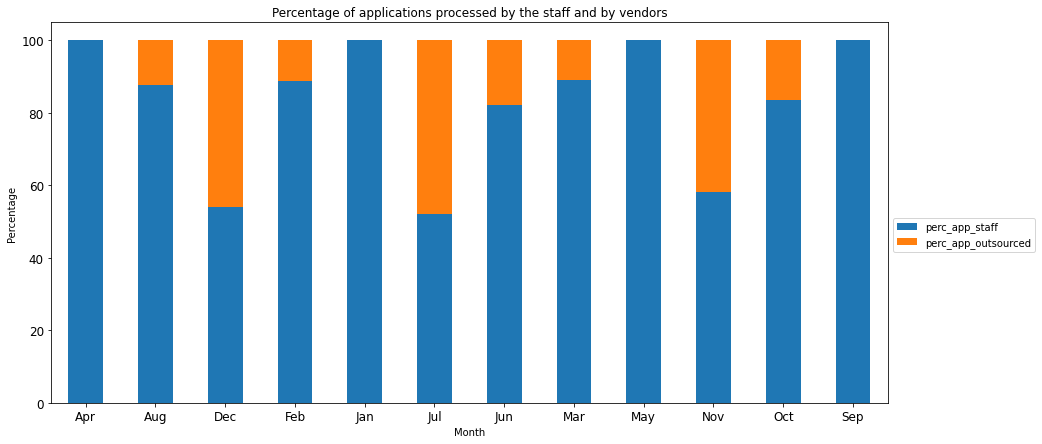

In [ ]:
# Creating a dataframe to use for visualization
Output_viz = Output.groupby("Month")["num_app_staff","num_app_outsourced",	"total_applications"].sum()

Output_viz['num_app_staff'] = Output_viz['num_app_staff']/Output_viz['total_applications']*100
Output_viz['num_app_outsourced'] = Output_viz['num_app_outsourced']/Output_viz['total_applications']*100

Output_viz = Output_viz.rename(columns={"num_app_staff": "perc_app_staff", "num_app_outsourced": "perc_app_outsourced"})
Output_viz = Output_viz.drop("total_applications",axis = 1)


# Plotting percentage of applications processed by the staff and by the outsourced vendor using stacked column chart

ax = Output_viz.plot(kind = 'bar', stacked = True,figsize = (15,7), ylabel = "Percentage", rot = 360, fontsize = 12,
                title='Percentage of applications processed by the staff and by vendors')

ax.legend(loc='best', bbox_to_anchor=(1.0, 0.5))

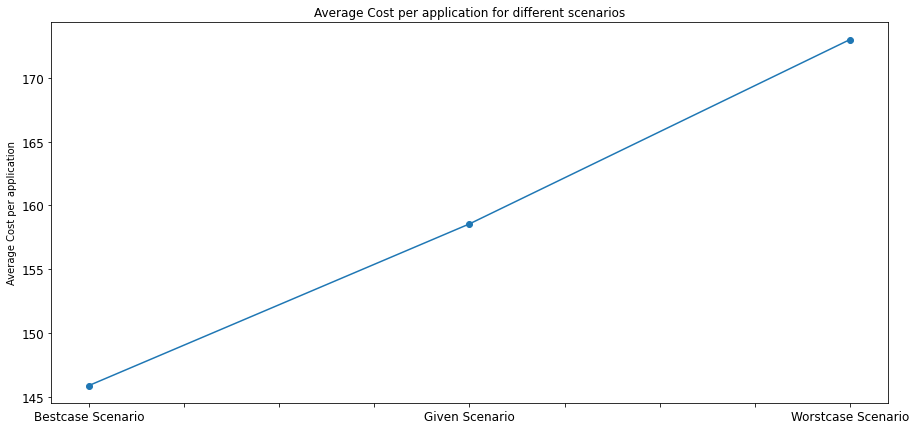

In [ ]:
# Creating a dataframe to use for visualization
Cost_per_app = {'Bestcase Scenario': [145.88],'Given Scenario': [158.55] ,'Worstcase Scenario': [173.0]}
Cost_per_app_df = pd.DataFrame(Cost_per_app)

# Plotting line chart to show how the cost per application increases with respect to any change in the parameters 

Cost_per_app_df.T.plot(kind = 'line',figsize = (15,7), ylabel = "Average Cost per application", fontsize = 12,  marker='o', legend = None,
                title='Average Cost per application for different scenarios')



*   Average cost per application is the lowest for the “Best Case Scenario” (145.88 dollars) whereas it is the highest for the “Worst Case Scenario” (173 dollars), an increase of 27.12 dollars
*   Average cost per application in the “Given Case Scenario” is 158.55 dollars


In [ ]:
# Creating a dataframes to use for visualization

worst_case_output_viz = worst_case_output.groupby("State")["avg_cost_per_app"].sum()
worst_case_output_viz = worst_case_output_viz.reset_index()
worst_case_output_viz = worst_case_output_viz.rename(columns = {"avg_cost_per_app":"worstcase_avg_cost_per_app"})

best_case_output_viz = best_case_output.groupby("State")[["avg_cost_per_app"]].sum()
best_case_output_viz = best_case_output_viz.reset_index()
best_case_output_viz = best_case_output_viz.rename(columns = {"avg_cost_per_app":"bestcase_avg_cost_per_app"})
best_case_output_viz

Output["givencase_avg_cost_per_app"] = round(Output['total_cost']/Output['total_applications'],2)
given_case_output_viz = Output.groupby("State")[["givencase_avg_cost_per_app"]].sum()
given_case_output_viz = given_case_output_viz.reset_index()
given_case_output_viz

avg_cost_three_cases = best_case_output_viz.merge(given_case_output_viz, on='State',how = "inner" ).merge(worst_case_output_viz,on='State',how = "inner").set_index("State")
avg_cost_three_cases = avg_cost_three_cases.rename(columns = {"bestcase_avg_cost_per_app":"Best-case scenario", "givencase_avg_cost_per_app":"Given scenario","worstcase_avg_cost_per_app":"Worst-case scenario" })
avg_cost_three_cases

,Best-case scenario,Given scenario,Worst-case scenario
State,,,
A,1846.68,2017.20,2234.93
B,1685.07,1821.98,1971.40
C,1631.22,1772.54,1898.18


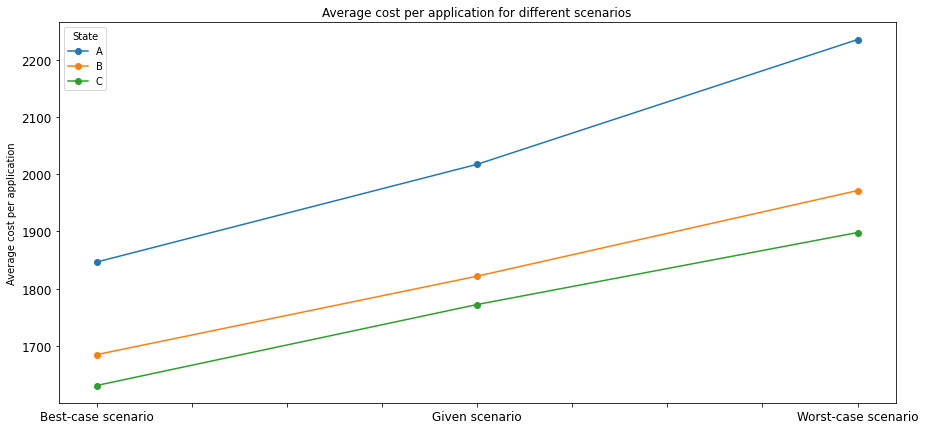

In [ ]:
# Plotting line chart to show how the cost per application increases with respect to any change in the parameters for each

avg_cost_three_cases.T.plot(kind = 'line',figsize = (15,7), ylabel = "Average cost per application", fontsize = 12,marker='o',
                title='Average cost per application for different scenarios')

State A has the highest overall average cost per application for all the three scenarios, followed by State B and State C.

# Fin!